In [1]:
from classifier import Embedder, DishClassifier, val_transform
import pickle

import torch
from torchvision import transforms
import numpy as np

import cv2

In [2]:
from utils.functions import SavePath
from layers.output_utils import postprocess, undo_image_transformation

from data import cfg, set_cfg, set_dataset

In [3]:
from yolact import Yolact
from utils.augmentations import BaseTransform, FastBaseTransform, Resize


import torch.backends.cudnn as cudnn

In [4]:
from PIL import Image

In [5]:
from classifier import SquarePad
import torch.nn.functional as F
from torch import nn

### load classifier

In [6]:
device = torch.device("cuda")

embedder = Embedder().to(device)                                                   
embedder.eval()                                                                         

with open("./weights/labels.pkl", "rb") as inpf:                               
    labels = np.array(pickle.load(inpf))                                                          

classifier = DishClassifier(                                                            
    embedder,                                                                           
    emb_size=1280,                        
    n_classes=len(labels)                                                               
)                                                                                            

classifier.load_state_dict(torch.load("./weights/classifier.pth"))        
classifier.to(device)                                                              
classifier.eval()                                                              

## Yolcat segmenter

In [7]:
trained_model = "weights/yolact_base_54_800000.pth"

In [8]:
model_path = SavePath.from_str(trained_model)

In [9]:
config = model_path.model_name + '_config'
set_cfg(config)

cfg.rescore_bbox = True
cfg.mask_proto_debug = False

cudnn.fastest = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [10]:
net = Yolact()
net.load_weights(trained_model)
net.eval()

/mnt/disk/projects/yolact/venv/lib/python3.6/site-packages/torch/jit/_recursive.py:165: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/mnt/disk/projects/yolact/venv/lib/python3.6/site-packages/torch/jit/_recursive.py:165: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/mnt/disk/projects/yolact/venv/lib/python3.6/site-packages/torch/jit/_recursive.py:165: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))


In [11]:
%%capture
net.cuda()

### Test model

In [12]:
img = cv2.imread("./in.jpg")

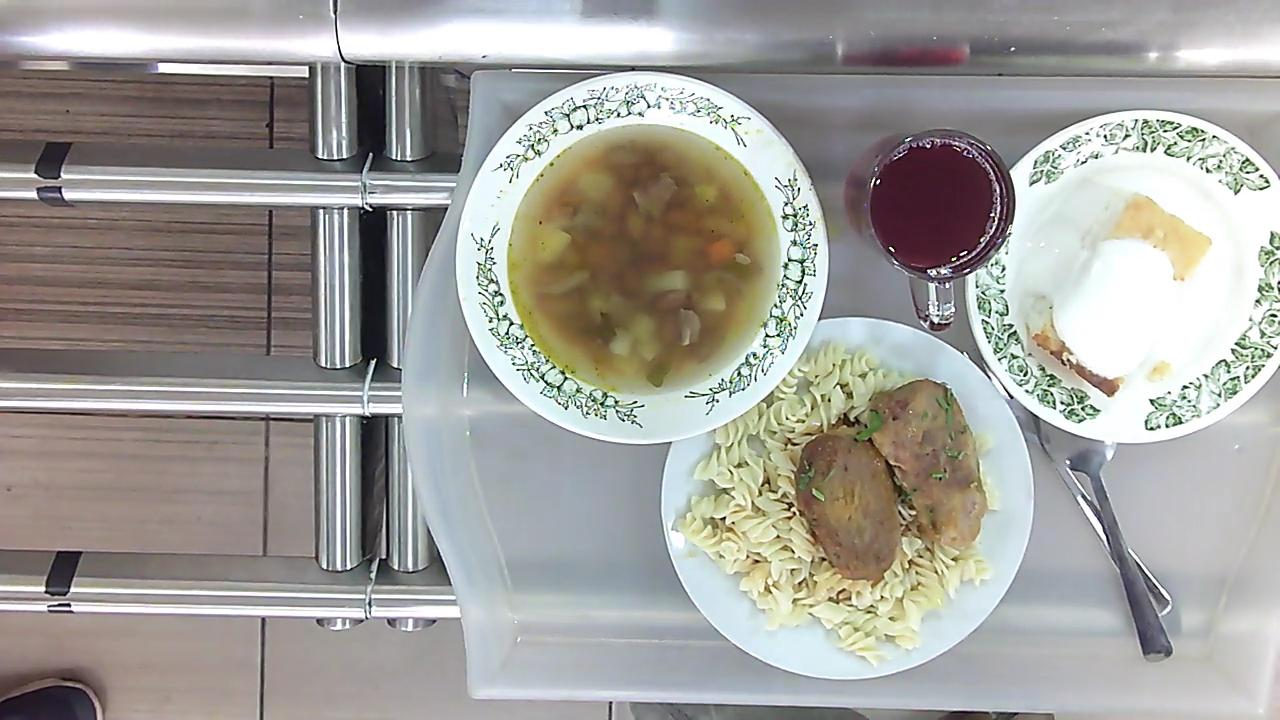

In [13]:
# show img
Image.fromarray((img).astype(np.uint8)[:,:,::-1])

In [14]:
## predict segments

In [15]:
%%time
with torch.no_grad():
    frame = torch.from_numpy(img).cuda().float()
    batch = FastBaseTransform()(frame.unsqueeze(0))
    preds = net(batch)

CPU times: user 261 ms, sys: 20.5 ms, total: 282 ms
Wall time: 282 ms


In [16]:
h, w, _ = frame.shape
results = postprocess(preds, w, h, visualize_lincomb=False,
                      crop_masks=True, score_threshold=0.5)

In [17]:
%%time
box_tensors = []
if results and len(results):
    for box_idx in range(len(results[0])):
        x1, y1, x2, y2 = results[2][box_idx]
        mask = results[3][box_idx]
        mask = mask.unsqueeze(2).repeat((1, 1, 3))
        box_img_tensor = box_img = mask[y1:y2, x1:x2, ] * frame[y1:y2, x1:x2, ]
        box_tensors.append(box_img_tensor)

CPU times: user 1.33 ms, sys: 1.07 ms, total: 2.4 ms
Wall time: 1.56 ms


In [18]:
img_transform = transforms.Compose([   
    transforms.Lambda(lambda x: x.data.cpu().numpy().astype(np.uint8)[:,:,::-1]),
    transforms.ToPILImage(),
    SquarePad(1),                                                                                    
    transforms.Resize((248, 248)),                                                                   
    transforms.ToTensor(),                                                                           
    transforms.Normalize(mean=[0.485, 0.456, 0.406],                                                 
                         std=[0.229, 0.224, 0.225])                                                  
])      

In [19]:
batch = torch.stack([img_transform(x).cuda() for x in box_tensors])

In [20]:
probas = nn.Softmax(dim=1)(classifier.forward(batch)).data.cpu().numpy() 
batch_argprobas = np.argsort(-probas, axis=1)  
batch_labels = labels[batch_argprobas[:, 0]] 

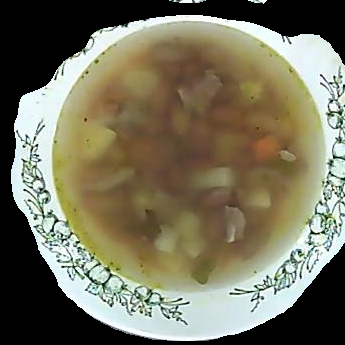

In [21]:
Image.fromarray((box_tensors[0]).data.cpu().numpy().astype(np.uint8)[:,:,::-1])

In [22]:
print(batch_labels[0])

Суп фасолевый с мясом 1/250


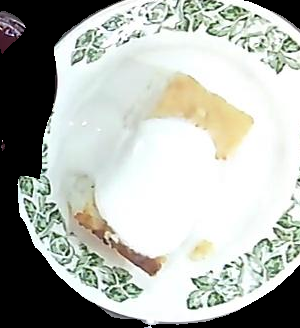

In [23]:
Image.fromarray((box_tensors[3]).data.cpu().numpy().astype(np.uint8)[:,:,::-1])

In [24]:
print(batch_labels[3])

Оладьи со сгущенным молоком 150/50


In [25]:
## just for time mesausrement

In [28]:
%%time

with torch.no_grad():
    frame = torch.from_numpy(img).cuda().float()
    batch = FastBaseTransform()(frame.unsqueeze(0))
    preds = net(batch)
    
    h, w, _ = frame.shape
    results = postprocess(preds, w, h, visualize_lincomb=False,
                          crop_masks=True, score_threshold=0.5)
    
    box_tensors = []
    if results and len(results):
        for box_idx in range(len(results[0])):
            x1, y1, x2, y2 = results[2][box_idx]
            mask = results[3][box_idx]
            mask = mask.unsqueeze(2).repeat((1, 1, 3))
            box_img_tensor = box_img = mask[y1:y2, x1:x2, ] * frame[y1:y2, x1:x2, ]
            box_tensors.append(box_img_tensor)
            
            batch = torch.stack([img_transform(x).cuda() for x in box_tensors])
            probas = nn.Softmax(dim=1)(classifier.forward(batch)).data.cpu().numpy() 
            batch_argprobas = np.argsort(-probas, axis=1)  
            batch_labels = labels[batch_argprobas[:, 0]] 

CPU times: user 528 ms, sys: 8.75 ms, total: 536 ms
Wall time: 207 ms
